In [1]:
#step one - get records and everything from elasticsearch

from elasticsearch import Elasticsearch
import certifi

endpoint = 'https://search-data-pipeline-poc-bdfr3wal5lxncg2zllpoo6nd2e.us-east-1.es.amazonaws.com'
client = Elasticsearch(endpoint, use_ssl=True, verify_certs=True, ca_certs=certifi.where())

doc = {
        'size' : 10000,
        'query': {
            'match_all' : {}
       }
   }

searchResults = client.search(index='metadata_on_datasets', doc_type='metadata_on_datasets_type', body=doc,scroll='1m')

# metadata = client.mget(index='metadata_on_datasets')

In [2]:
metadata = searchResults['hits']['hits']

In [3]:
# for now, we're just clustering IDs by dataset_notes, dataset_description, dataset_name, dataset_tags, and dataset_keywords

In [4]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
# nltk.download('punkt')
# nltk.download('stopwords')

# Preprocessing


In [5]:
datasetIdentifiers = [(item['_id'], item['_source']['dataset_name']) for item in metadata]
#clean out html tags. clean out \xa0 and \n newlines as well. 
datasetClusteringInfo = []
for item in metadata:
    notes = re.sub(r"<[^>]*>", " ", item['_source']['dataset_notes'])
    #remove urls from the description (e.g. https://www.epa.gov/air/ozonepollution/)
    notes = re.sub(r'http\S+', '', notes)
    #remove new line characters 
    notes = re.sub(r"\n", " ", notes)
    notes = re.sub(r"\r", " ", notes)
    #remove artifacts from different text encodings (e.g. /xa0) 
    #notes = re.sub(r"\([a-z][a-z][0-9])", " ", notes) 

    datasetClusteringInfo.append(notes + ' ' + item['_source']['dataset_name'])


### choosing what words to ignore

Pre-built corpus of words to ignore provided by nltk. Manually add some stuff that obviously is non-useful but is being clustered on anyways.

In [10]:
stopwords = nltk.corpus.stopwords.words('english') + ['health', 'dataset', 'data', 'zipcode', 'new york', 'chicago', 'Chicago', 'york', 'New York', 'Maryland', 'maryland']

### stemming and tokenizing

In [7]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [8]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [9]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for info in datasetClusteringInfo:
    allwords_stemmed = tokenize_and_stem(info) 
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(info)
    totalvocab_tokenized.extend(allwords_tokenized)

# lookup table to convert stemmed words back to original vocab
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

## vectorizing words

define vectorizer parameters. Tuning the parameters here is extremely important; a lot of 'dummy' features come up such as 'u.s.', 'https', 'data', etc. Manually identify and remove those. Specifying how often a word needs to appear to be considered a 'feature', whether a word that appears too often would be considered irrelevant (e.g. something like 'health' would be useless for classification), how many words we want to use as features.

Todo: Give more weight to medical related terms (e.g. 'drugs' might appear with similar frequency as 'program', but one is more medically informative). 

0. create dictionary of 'medical terms' https://www.academicvocabulary.info/compare.asp 
1. find vector of features that correspond to interesting 'medical' words
2. weight vector by some scalar. Should not have a different weight across different medical terms

Todo: Give less weight to location names. Right now, things like 'new york' and datasets related to NY are a cluster. This might make sense moving forward, but don't want it rn for the sake of visualization.

In [11]:
# construct medical word corpus
medical_corpus = pd.read_csv('./medical_words.csv')
med_word_set = set(medical_corpus['word'])

# construct location word corpus; for now just use observed words
location_word_corpus = set(['Maryland', 'New York', 'york', 'new'])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_df=0.4, max_features=200000,
                                 min_df=5, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(datasetClusteringInfo) #fit the vectorizer to our dataset info

In [13]:
for stemmed_words, index in tfidf_vectorizer.vocabulary_.items():
    actual_words = vocab_frame.loc[stemmed_words.split(' ')]['words'].unique()
    medical_related = False
    for word in actual_words:
        if word in med_word_set:
            medical_related = True
        
    
    tfidf_matrix[:, index] *= 10
    
    
    
    

In [29]:
terms = tfidf_vectorizer.get_feature_names()

In [14]:
#compute 'distances' between words and clusters; reduce down to 2D space with MDS or PCA.
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

dist = 1 - cosine_similarity(tfidf_matrix)

MDS()

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  

xs, ys = pos[:, 0], pos[:, 1]

# 🅱️-Means computation

In [24]:
from sklearn.cluster import KMeans

num_clusters = 25

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [25]:
from sklearn.externals import joblib
joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')

In [26]:
clusters = km.labels_.tolist()

dataClusterDict = { 'identifier': datasetIdentifiers, 'desc': datasetClusteringInfo, 'cluster': clusters}

dataClusterDf = pd.DataFrame(dataClusterDict, index = [clusters])

In [27]:
dataClusterDf['cluster'].value_counts()

20    125
13     68
1      44
18     35
17     31
3      27
11     26
7      25
8      24
12     23
4      19
6      17
0      17
15     17
19     17
22     17
5      16
21     16
9      15
16     13
2      13
14     11
10     10
24      6
23      5
Name: cluster, dtype: int64

In [30]:
# examine clusters/words that were clustered on to see if it makes sense; store results

clusterWordsDict = {}
clusterDocsDict = {}

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    
    wordsForThisCluster = []
    docsInThisCluster = []
    
    for j in order_centroids[i, :10]: 
        word = vocab_frame.ix[terms[j].split(' ')].values[0][0]
        wordsForThisCluster.append(word)
    clusterWordsDict[i] = wordsForThisCluster
    
    for docIdentifier in dataClusterDf.ix[i]['identifier'].values.tolist():
        docsInThisCluster.append(docIdentifier[1])
    clusterDocsDict[i] = docsInThisCluster
    
    print('cluster ' + str(i) + ' words: ' + str(wordsForThisCluster))
    print()
    print('cluster ' + str(i) + ' documents: ' + str(docsInThisCluster))
    print()
    


/Users/gaoag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


cluster 0 words: ['infections', 'oregon', 'dialysis', 'reported', 'table', 'bloodstream', 'bloodstream', 'baseline', 'bsi', 'bsi']

cluster 0 documents: ['2015 Dialysis AR BSI TABLE', '2016 Methicillin-Resistant Staphylococcus aureus (MRSA) Bloodstream Infection (BSI) Laboratory-Identified (LabID) Events Table – Long-Term Acute Care Hospitals (Updated Baseline)', '2016 Catheter-Associated Urinary Tract Infections (CAUTI) Table – Inpatient Rehabilitation Facilities (Updated Baseline)', '2016 Hospital-Onset (HO) Clostridium difficile Infection (CDI) Laboratory-Identified (LabID) Events Table – Acute Care Hospitals (Updated Baseline)', '2015 Complex SSI Table for All Reportable Surgical Procedures', '2016 Dialysis Bloodstream Infections (BSI) Table', '2016 Hospital-Onset (HO) Clostridium difficile Infection (CDI) Laboratory-Identified (LabID) Events Table – Critical Access Hospitals (Updated Baseline)', '2016 Hospital-Onset (HO) Clostridium difficile Infection (CDI) Laboratory-Identified 

cluster 12 words: ['clinic', 'public', 'public', 'primary', 'primary', 'registrations', 'outpatient', 'care', 'community', 'department']

cluster 12 documents: ['Public Health Clinics', 'Rural Health Clinics', 'Health and Hospitals System-2009 Total Outpatient Registrations By ZIP', 'Health & Hospitals System - Outpatient Registrations, by Month, by ZIP - Fiscal Year 2009', 'STD HIV Clinic', 'Public Health Clinics', 'Performance Metrics - Public Health - Percent Served at STI Specialty Clinics', 'Neighborhood Health Clinics - Historical', 'Health & Hospitals System - Outpatient Registrations, by Facility, Zip Code, Month - Fiscal Year 2011', 'Safety Net Clinics', 'Rural Health Clinics', 'Public Health Services- Chicago Primary Care Community Health Centers', 'Public Health Clinics', 'VA Community Based Outpatient Clinics, FY2013', 'VA Community Based Outpatient Clinics, FY2014', 'Health and Hosptials--2008 Total Outpatient Registrations By ZIP', 'Health & Hospitals System - Outpatient 

cluster 23 words: ['birth', 'death', 'marriages', 'marriages', 'birth', 'civil', 'civil', 'death', 'marriages', 'unions']

cluster 23 documents: ['Hawaii County Births, Deaths, Marriages, Civil Unions 2012', 'Kauai County Births, Deaths, Marriages, Civil Unions 2012', 'Honolulu County Births, Deaths, Marriages, Civil Unions 2012', 'Statewide Births, Deaths, Marriages, Civil Unions 2012', 'Maui County Births, Deaths, Marriages, Civil Unions 2012']

cluster 24 words: ['members', 'board', 'veterans', 'active', 'services', 'family', 'oregon', 'payments', 'licensed', 'enrolled']

cluster 24 documents: ['Member Health Subsidy', 'Member Health Subsidy', 'Member Health Subsidy', 'DMH Veterans Provider Enrollment', '[Known Issue] Lobbyist Activity - Activity Expenses', 'OHLA Board Members']



In [127]:
shit_cluster = set(['Allegheny County Toxics Release Inventory', 'New York City Work and Family Leave Survey (WFLS) 2014', 'Bureau of Fire Prevention - Certificates of Fitness', 'Allegheny County Plumbers', 'Hospitals', 'Imagine Austin Indicators', 'FDNY Monthly Response Times', 'Allegheny County Housing and Community Environment Inspections', 'Children and Family Health and Well-Being (2015)', 'Maryland Department of Health (MDH) Dashboard Measures', 'Current Reservoir Levels', 'Health & Hospitals - Outpatient Registrations, by Zip Code - 2011', 'OEM Training Calendar', 'USEPA Environmental Quality Index (EQI) and Associated Domain Indices by County for the United States', 'NCHS - Birth Rates for Unmarried Women by Age, Race, and Hispanic Origin: United States', 'Behavioral Service Providers', 'Hawaii County Births, Deaths, Marriages, Civil Unions 2012', 'Number of Deaths for Selected Causes among Maryland Residents, 1992-2015', 'Hospital Inpatient Discharges by DRG, U.S., FY2011', 'Heart Attack Payment - National', "President's Office--Juvenile Temporary Detention Center Cost Comparison", 'Austin Public Health Locations', 'Community Health Survey', 'Youth Behavior Risk Survey', 'PONE-D-15-23803', "Most Popular Baby Names by Sex and Mother's Ethnic Group, New York City", 'VA Outpatient Visits by Administrative Parent, FY2010-2014', '2015-16 Local Law 15 Health Data - K-12 Health Instructors', '2015-16 Local Law 15 Health Data K-12 Health Instructor CCD', 'Global Tobacco Surveillance System (GTSS) - Global Health Professions Student Survey (GHPSS)', 'University of Illinois at Chicago Health Policy Center - Funding', 'Population Health Measures: Age-Adjusted Mortality Rates', 'BRFSS Prevalence And Trends Data: Health Care Access/Coverage for 2011', 'Permitted Medical Cannabis Dispensaries', 'Allegheny County Supermarkets & Convenience Stores', 'Question Inventory on Tobacco (QIT)', 'Maryland Adult Cigarette Smoking Status, 1995-2010', 'Youth Marijuana Use 2004-2012 (even years)', 'Allegheny County Greenways', 'Table 2: FY2013 Distribution of Net Change in Base Operating DRG Payment Amount', 'Kauai County Births, Deaths, Marriages, Civil Unions 2012', 'OIE-FAVN TEST RESULTS BY MICROCHIP - under construction with test data', 'Natality', 'Connecticut Resident Deaths, 1999-2011, Selected Causes of Death by Age, Sex, Race and Hispanic Ethnicity', 'Heart Attack Payment - State', 'U.S. Daily Climate Normals (1981-2010)', 'Community Health Survey', 'Occupational Health Indicators', 'LymeDisease_9211_county', 'Occupational Health Indicators', 'Benefits and Programs API', 'Design & Construction Capital Projects Vendor Payments:  Beginning 2014', 'Youth and Family Initiative All Top Priorities', 'Deaths By Neighborhood 2008 - 2012', 'Electronic Health Information Legal Epidemiology Data Set 2014', 'Health & Hospitals System - Outpatient Registrations By ZIP - Fiscal Year 2010', 'VA Operating Beds by Administrative Parent, FY2010-FY2014', 'Children and Family Health & Well-Being (2010-2014)', 'BRFSS Prevalence And Trends Data: Health Care Access/Coverage for 1995-2010', 'Connecticut Health and Educational Facilities Authority Financial Data FY 2015', 'Restaurant Scores - LIVES Standard', 'Supply Chain Shipment Pricing Data', 'SENTINEL SITES WHM- 11-14-2014', 'Cross-sectional Survey of Urinary Aflatoxins and Diet Recall in Haiti', 'CDC Best Practices for Comprehensive Tobacco Control Programs - 2014', 'Allegheny County Older Housing', 'Honolulu County Births, Deaths, Marriages, Civil Unions 2012', 'Maryland Total Deaths By Year: 2000-2015', 'Statewide Births, Deaths, Marriages, Civil Unions 2012', 'Number of Deaths among Maryland Residents, 1902-2015', 'NCHS - Potentially Excess Deaths from the Five Leading Causes of Death', 'NYC Independent Budget Office (IBO) Revenue And Spending Summary FY 1980 - FY 2013', 'Directory of History of Medicine Collections (DHMC)', 'Healthy incentives grid', 'Utilization and Costs of Health Services for Medicare Fee-for-Service Beneficiaries, Washington State and Counties, 2007-2014', 'NCHS - Births to Unmarried Women by Age Group: United States', 'USEPA Environmental Quality Index (EQI) - Air, Water, Land, Built, and Sociodemographic Domains Non-Transformed Variables Dataset as Input for the USEPA EQI, by County for the United States', 'GTS Surficial Aquifers', 'Allegheny County Walk Scores', 'Montgomery County Council Legislation - Bills', 'HHS Nursing Homes', 'Birth Rate, State of Hawaii 1900 - 2011', 'State Administered General Assistance: Department of Social Services', 'AOT (Assisted Outpatient Treatment) Court Orders', 'Ambulatory Surgical Centers', 'Percents of Chronic Conditions among Fee-for-Service Medicare Beneficiaries, Washington State and Counties, 2007-2014', 'Maryland Total Births By Year: 2000-2015', 'Medicare Beneficiary Enrollment and Demographics, Washington State and Counties, 2007-2014', 'Maryland Net Natural Gain (Births Minus Deaths) By Year: 2000-2015', 'Personal  Income Tax Voluntary Contributions:  Beginning Fiscal Year 1983', 'Austin Public Health Locations', 'Survey Monument', 'Railroads', 'Campaign Finance - Data Key', 'WTC Disorders', 'Loudoun Drainfields', 'Loudoun Wells', '2016 Dental Loss Ratios', 'HealthChoice Medicare Supplement Plans Medications with Quantity Limits', 'Number of Drug and Alcohol-Related Intoxication Deaths by Place of Occurrence, 2007-2016[1][2]', 'Healthy People 2020 Tobacco Use Objectives', 'Suburban Cook County - Births (Birth Related Outcomes & Characteristics)', 'CDC Best Practices for Comprehensive Tobacco Control Programs - 2007', 'Allegheny County Median Age at Death', 'Hospital Inpatient Discharges by DRG, Northwest, FY2011', 'Maui County Births, Deaths, Marriages, Civil Unions 2012', 'Hospital Inpatient Discharge Rates, Average Charges, Average Payments, and Charge-to-Payment Ratios by DRG - U.S., Northwest, and Washington State - FY2011', 'Home Occupation Certificates', 'Daily Inmates In Custody', 'OIP Master UIPA Record Request Year- End Log For FY 2014 19mar15'])

# K-Means Visualization

dawg this shit sucks 

should be expected that kmeans on its own wouldn't work well though - gonna try the weighting thing

/Users/gaoag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


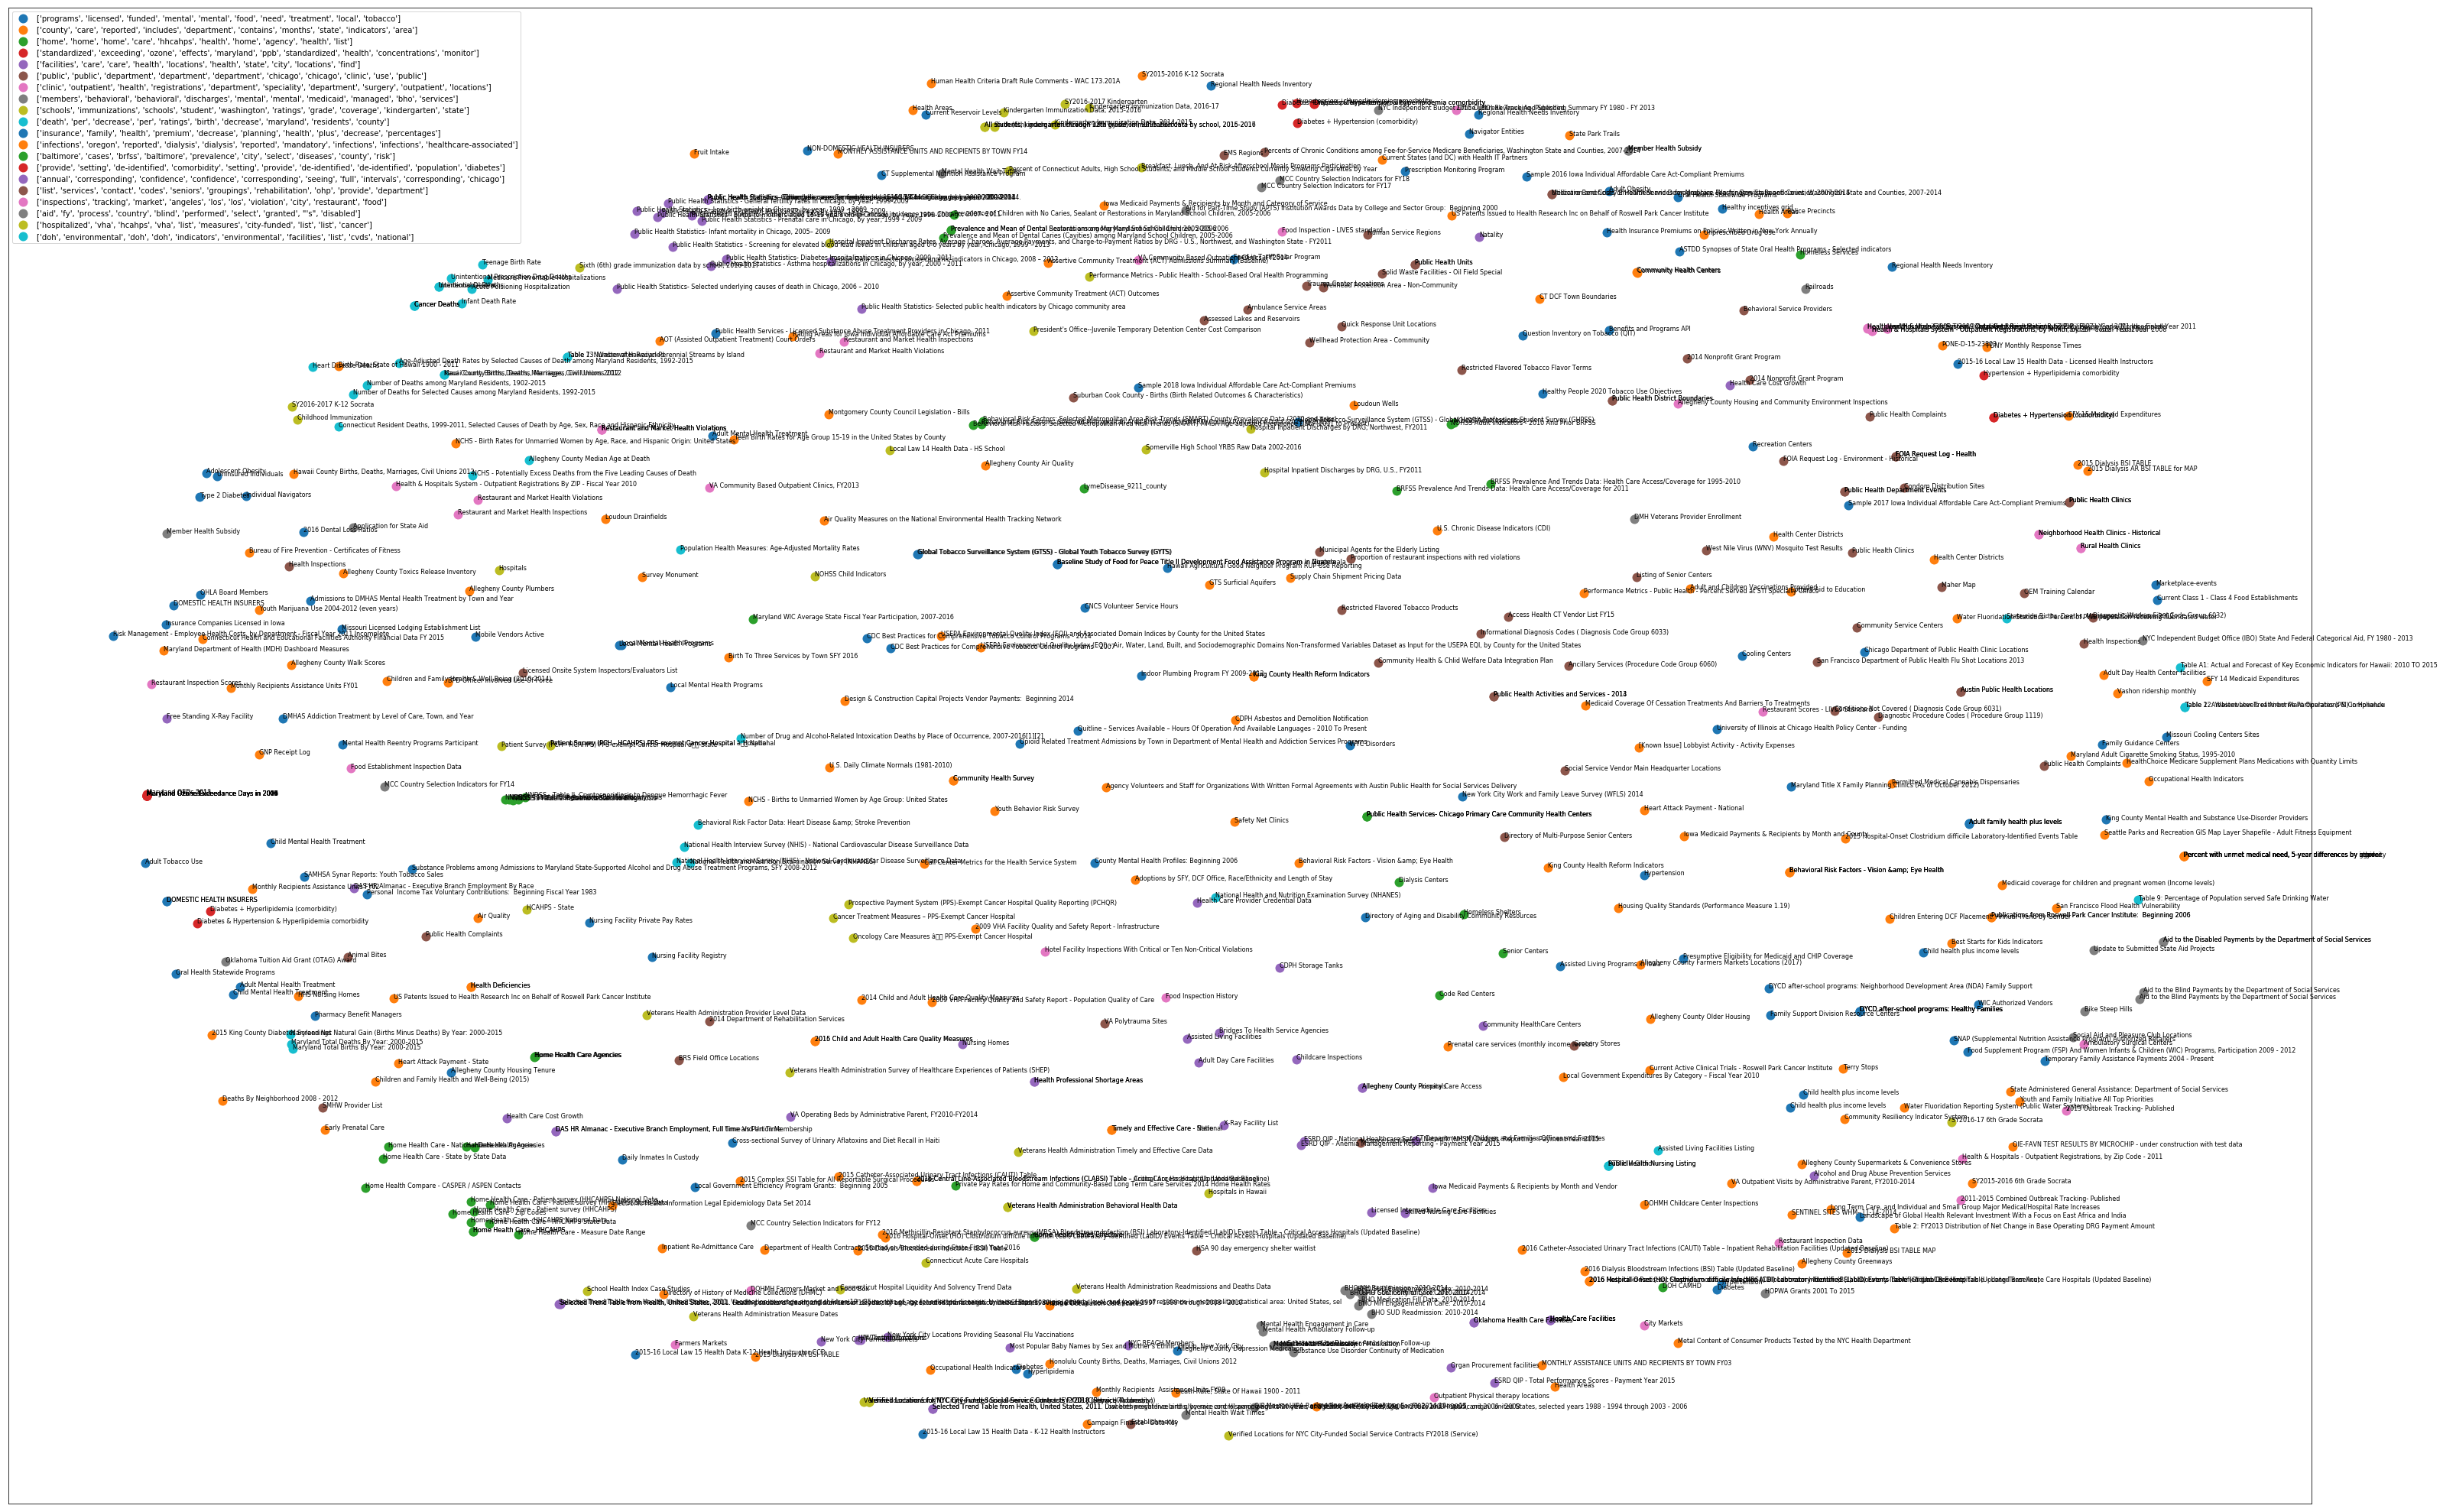

In [180]:
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline 

kMeansDf = pd.DataFrame(dict(x=xs, y=ys, label=clusters, identifier=datasetIdentifiers)) 

kMeansGroupedByCluster = kMeansDf.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(54, 36))

for name, group in kMeansGroupedByCluster:
    ax.plot(group.x, group.y, marker='o', ms=12, mec='none', linestyle='', label=clusterWordsDict[name])
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the document name
for i in range(len(kMeansDf)):
    ax.text(kMeansDf.ix[i]['x'], kMeansDf.ix[i]['y'], kMeansDf.ix[i]['identifier'][1], size=8)  

    
    
# plt.show() 

#uncomment the below to save the plot if need be
plt.savefig('clusters.png', dpi=200)


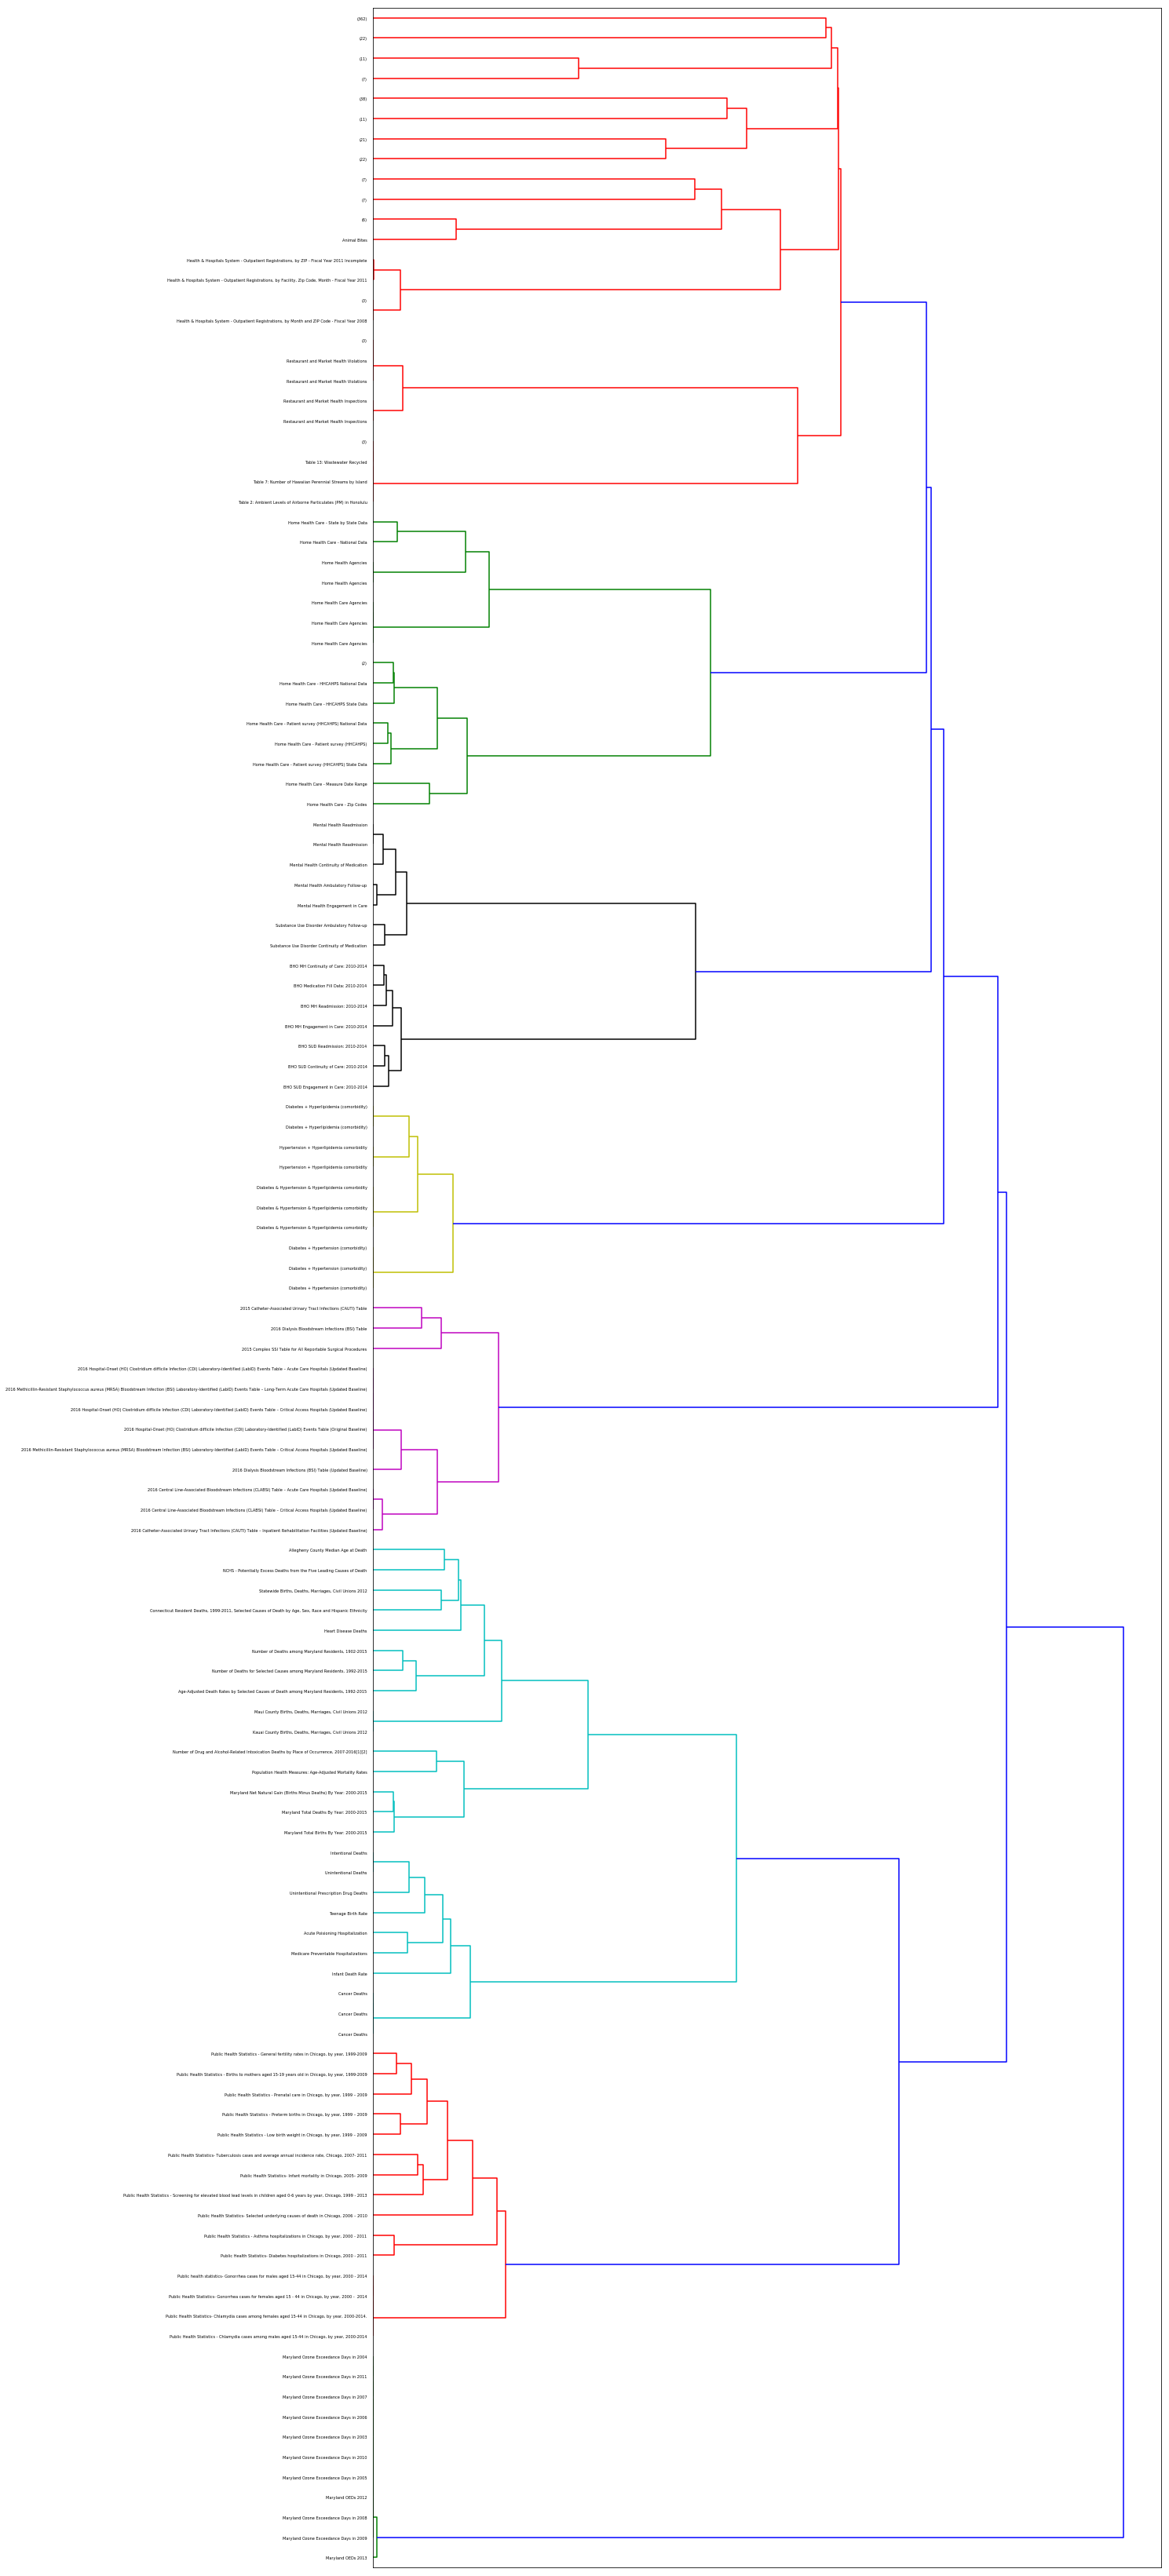

In [192]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(18, 60)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=[d[1] for d in datasetIdentifiers], truncate_mode='level', p=10);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

